# AI-LAB LESSON 6: Deep Reinforcement Learning

In this lesson we will use the CartPole environment and we will see how to create and work with a neural network using Kears on top of Tensorflow.

## CartPole
The environment used is **CartPole** (taken from the book of Sutton and Barto as visible in the figure)

![Cartpole](images/cartpole.jpg)

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

In [1]:
import os, sys, tensorflow.keras, random, numpy
module_path = os.path.abspath(os.path.join('../tools'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gym, envs
from utils.ai_lab_functions import *
from timeit import default_timer as timer
from tqdm import tqdm as tqdm
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

The **state** of environment is represented as a tuple of 4 values: 
- *Cart Position* range from -4.9 to 4.8
- *Cart Velocity* range from -inf to +inf
- *Pole Angle* range from -24 deg to 24 deg
- *Pole Velocity* range from -inf to +inf

The **actions** allowed in the environment are 2:
- *action 0*: push cart to left
- *action 1*: push cart to right

The **reward** is 1 for every step taken, including the termination step.

In [2]:
env = gym.make("CartPole-v1")
state = env.reset()
print("STARTING STATE: {}".format(state))
print("\tCart Position: {}\n\tCart Velocity {}\n\tPole Angle {} \n\tPole Velocity {}".format(state[0], state[1], state[2], state[3]))

print("\nPOSSIBLE ACTIONS: ", env.action_space.n)

STARTING STATE: [-0.01579754 -0.02245492  0.04781105 -0.00225107]
	Cart Position: -0.015797540049169667
	Cart Velocity -0.022454923268852935
	Pole Angle 0.04781105117005684 
	Pole Velocity -0.0022510677825031827

POSSIBLE ACTIONS:  2


Finally, we still have the standard functionalities of a Gym environment:
- step(action): the agent performs action from the current state. Returns a tuple (new_state, reward, done, info) where:
    - new_state: is the new state reached as a consequence of the agent's last action
    - reward: the reward obtained by the agent in this step
    - done: True if the episode is terminal, False otherwise
    - info: not used, you can safely discard it

- reset(): the environment is reset and the agent goes back to the starting position. Returns the initial state id

## Neural network with Kears
**Keras** is an open-source neural-network library written in Python. It is capable of running on top of TensorFlow, Microsoft Cognitive Toolkit, R, Theano, or PlaidML. Designed to enable fast experimentation with deep neural networks, it focuses on being user-friendly, modular, and extensible.

![Network](images/neural_networks.png)

With kears you can easly create a neural network with the **Sequential** module. Before training a neural netowrk you must compile it, selecting the loss function and the optimizer, in our experiment we will use the *mean_squared_error* for the loss function and the *adam* optimizer, that is a standard configuration for a DQN problem.

In [3]:
input_layer = 3
layer_size = 5
output_layer = 2

model = Sequential()
model.add(Dense(layer_size, input_dim=input_layer, activation="relu")) #input layer + hidden layer #1
model.add(Dense(layer_size, activation="relu")) #hidden layer #2
model.add(Dense(layer_size, activation="relu")) #hidden layer #3
model.add(Dense(layer_size, activation="relu")) #hidden layer #4
model.add(Dense(layer_size, activation="relu")) #hidden layer #5
model.add(Dense(output_layer, activation="linear")) #output layer

model.compile(loss="mean_squared_error", optimizer='adam') #loss function and optimzer definition

In Keras you can compute the output of a network with the **predict** function, that requires in input the values of the input layer nodes and returns the corresponding values of the output layer.

In [4]:
input_network = [random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)]
output_network = model.predict(np.array([input_network]))
print("Input network: {}".format(input_network))
print("network Prediction: {}".format(output_network[0]))

Input network: [0.1674825610999774, 0.6302852979183581, 0.49884956129790936]
network Prediction: [-0.01516445 -0.02208831]


To train a network in Keras we must use the function **fit**, that take as input:
- *input*: the input of the network that we are interested to train
- *expected_output*: the output that we consider correct
- *epochs*: the number of iteration for the backpropagation (in DQN this value is always 1).

In [5]:
input_network = [random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)]
expected_output = [0, 0]

print("Prediction 'before' training:")
print(model.predict(np.array([input_network])))

model.fit(np.array([input_network]), np.array([expected_output]), epochs=1000, verbose=0)

print("\nPrediction 'after' training:")
print(model.predict(np.array([input_network])))

Prediction 'before' training:
[[-0.01594068 -0.02321895]]

Prediction 'after' training:
[[0. 0.]]


Finally, remember that for all the methods (*fit*, *predict*, ...) keras requires as input a numpy array of array, for example you must convert your state in the correct **shape**.  Kears will return, in the same way, an array of array, so to extract the corresponding ouutput layer you must select the first element.

In [6]:
state = np.array([0, 0, 0])
# model.predict(input_network) will give you a shape error
state = state.reshape(1, 3)
print("Prediction:", model.predict(state)[0])

Prediction: [0.01743064 0.01560328]


## Assignment: Q-Learning

Your first assignement is to implement all the functions nexessary for a deep q-learning algorithm. In particular you must implement the following functions: *create_model*, *train_model* and *DQN*.

#### Hint:
For the experience replay buffer you can use the python data structure *dequeue*, defining the maximum length allowed. With the *random.sample(replay_buffer, size)* function you can sample *size* element from the queue:

In [7]:
replay_buffer = deque(maxlen=10000)
for _ in range(100): replay_buffer.append(random.uniform(0, 1))
    
samples = random.sample(replay_buffer, 3) 
print("Get 3 element from replay_buffer:", samples)

Get 3 element from replay_buffer: [0.7951751985628519, 0.11837116852095697, 0.9820342772598029]


In [8]:
def create_model(input_size, output_size, hidden_layer_size, hidden_layer_number):
    """
    Create the neural network model with the given parameters
    
    Args:
        input_size: the number of nodes for the input layer
        output_size: the number of nodes for the output layer
        hidden_layer_size: the number of nodes for each hidden layer
        hidden_layer_number: the number of hidden layers
        
    Returns:
        model: the corresponding neural network
    """

    model = Sequential()

    # Layer iniziale di input + hidden layer
    model.add(Dense(hidden_layer_size, input_dim=input_size, activation="relu"))
    
    # Hidden layers intermedi
    for _ in range(1, hidden_layer_number):
        model.add(Dense(hidden_layer_size, activation="relu"))

    # Layer finale di output
    model.add(Dense(output_size, activation="linear"))

    model.compile(loss="mean_squared_error", optimizer='adam')
    return model

In [9]:
def experience_replay(neural_network, memory, batch_size, gamma=0.99):
    """
    Performs the value iteration algorithm for a specific environment
    
    Args:
        neural_network: the neural network model to train
        memory: the memory array on wich perform the training
        batch_size: the size of the batch sampled from the memory
        gamma: gamma value, the discount factor for the Bellman equation
    """    
    
    TRAINING_EPOCHS  = 1
    TRAINING_VERBOSE = 0

    # Se non abbiamo abbastanza eventi per riempire un mini-batch
    # evitiamo di fare training
    if len(memory) < batch_size:
        return neural_network

    # Ottiene mini-batch dall'esperienza
    experience = random.sample(memory, batch_size)
    for event in experience:
        current_state, action, next_state, reward, done = event
        
        # Dato uno stato passato genera la nuova risposta del NN
        current_state = current_state.reshape(1, 4)
        target = neural_network.predict(current_state)[0]

        # Calcola reward dell'azione a seconda che lo stato sia terminale o no
        if done:
            target[action] = reward
        else:
            next_state = next_state.reshape(1, 4)
            max_q = max(neural_network.predict(next_state)[0])
            target[action] = reward + gamma * max_q

        # Training sulle esperienze
        target = target.reshape(1, 2)
        neural_network.fit(current_state, target, 
            epochs=TRAINING_EPOCHS, verbose=TRAINING_VERBOSE)
    
    return neural_network

In [10]:
def DQN(environment, neural_network, trials, goal_score, batch_size, epsilon_decay=0.9995):
    """
    Performs the Q-Learning algorithm for a specific environment on a specific neural network model
    
    Args:
        environment: OpenAI Gym environment
        neural_network: the neural network to train
        trials: the number of iterations for the training phase
        goal_score: the minimum score to consider 'solved' the problem
        batch_size: the size of the batch sampled from the memory
        epsilon_decay: the dacay value of epsilon for the eps-greedy exploration
        
    Returns:
        score_queue: 1-d dimensional array of the reward obtained at each trial step
    """


    epsilon = 1.0; epsilon_min = 0.01
    score_queue = []

    EXPERIENCE_BUFFER_LEN = 10000
    experience_buffer = deque(maxlen = EXPERIENCE_BUFFER_LEN)

    # Episodi di addestramento
    for trial in range(trials):
        
        current_state = environment.reset()

        # Numero di azioni prese per esplorazione o sfruttamento
        exploration  = 0
        exploitation = 0

        done = False
        trial_score = 0
        while not done:

            # Output del NN
            current_state = current_state.reshape(1, 4)
            nn_actions_score = neural_network.predict(current_state)[0]
                        
            # Con probabilità epsilon sceglie di esplorare e con prob. (1 - epsilon) di seguire la policy
            if random.uniform(0.0, 1.0) > epsilon:
                action = numpy.argmax(nn_actions_score)
                exploitation += 1
            else:
                action = environment.action_space.sample()
                exploration += 1

            # Rendiamo sempre meno probabile l'esplorazione
            epsilon = max(epsilon * epsilon_decay, epsilon_min)

            # Esegue l'azione scelta e salva il risultato nella cache di esperienza
            next_state, reward, done, _ = environment.step(action)
            experience_buffer.append([current_state, action, next_state, reward, done])
            
            neural_network = experience_replay(neural_network, experience_buffer, batch_size)
            trial_score = trial_score + reward
            current_state = next_state
            
        score_queue.append(trial_score)
        if trial_score > goal_score or score_queue == []: 
            break
        
        print("Episode: {:7.0f}, Score: {:3.0f}, ExpBufferSize: {:7.0f}, Exploitation: {:3.0f}, Exploration: {:3.0f}, EPS: {:3.5f}"
            .format(trial, score_queue[-1], len(experience_buffer), str(exploitation), str(exploration), epsilon))
    
    return neural_network, score_queue

In [11]:
env = gym.make("CartPole-v1")
neural_network = create_model(4, 2, 32, 2)
neural_network, score = DQN(env, neural_network, trials=1000, goal_score=130, batch_size=32)

Episode:       0, Score:  19, ExpBufferSize: 19, Exploitation: 0, Exploration: 19, EPS: 0.99054
Episode:       1, Score:  23, ExpBufferSize: 42, Exploitation: 0, Exploration: 23, EPS: 0.97921
Episode:       2, Score:  28, ExpBufferSize: 70, Exploitation: 1, Exploration: 27, EPS: 0.96560
Episode:       3, Score:  15, ExpBufferSize: 85, Exploitation: 1, Exploration: 14, EPS: 0.95838
Episode:       4, Score:  47, ExpBufferSize: 132, Exploitation: 2, Exploration: 45, EPS: 0.93612
Episode:       5, Score:  31, ExpBufferSize: 163, Exploitation: 2, Exploration: 29, EPS: 0.92171
Episode:       6, Score:  11, ExpBufferSize: 174, Exploitation: 1, Exploration: 10, EPS: 0.91666
Episode:       7, Score:  10, ExpBufferSize: 184, Exploitation: 1, Exploration: 9, EPS: 0.91208
Episode:       8, Score:  16, ExpBufferSize: 200, Exploitation: 0, Exploration: 16, EPS: 0.90481
Episode:       9, Score:  15, ExpBufferSize: 215, Exploitation: 0, Exploration: 15, EPS: 0.89805
Episode:      10, Score:  17, ExpBu

## Execution
The following code executes the DQN and plots the reward function, the execution could require up to 10 minutes on some computer. A more efficent version of the code can be found [here](https://github.com/d-corsi/BasicRL).
Correct results for comparison can be found here below. Notice that since the executions are stochastic the charts could differ: the important thing is the global trend and the final convergence to a visible reward improvement.

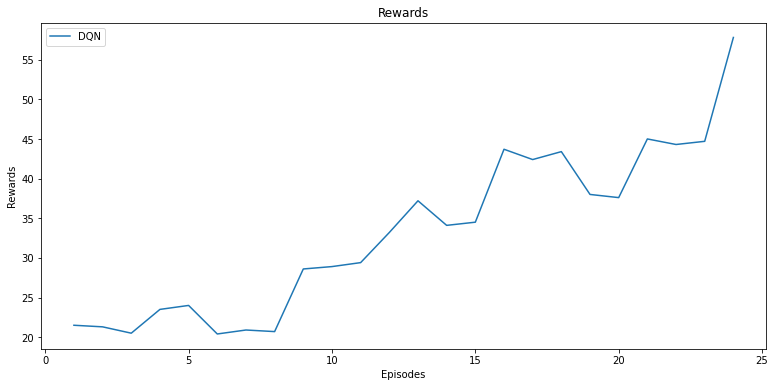

In [12]:
rewser = []
window = 10

score = rolling(np.array(score), window)
rewser.append({"x": np.arange(1, len(score) + 1), "y": score, "ls": "-", "label": "DQN"})
plot(rewser, "Rewards", "Episodes", "Rewards")

**Standard DQN on CartPole results:**
<img src="images/results-dqn.png" width="600">